# Optimization

## Import Libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd

from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2  # Multi-objective algorithm
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.core.problem import ElementwiseProblem

import src.optimization_utils as ou
import src.solutions as s

## Load Model

In [2]:
# Load BOTH models
bundle_mech_fail = ou.load_model_bundle("../artifacts/mech_fail_xgb.joblib")
bundle_composite = ou.load_model_bundle("../artifacts/composite_score_model.joblib")

print("Mechanical Failure Model:", bundle_mech_fail.get("model_name", "Unknown"))
print("Composite Score Model:", bundle_composite.get("model_name", "Unknown"))

Mechanical Failure Model: mech_fail_xgb
Composite Score Model: composite_histgb_reg


In [3]:
print(f"Mech Fail Features ({len(bundle_mech_fail['features'])}): {bundle_mech_fail['features']}")
print(f"Composite Features ({len(bundle_composite['features'])}): {bundle_composite['features']}")

Mech Fail Features (23): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop', 'UIV_implant', 'num_interbody_fusion_levels', 'ALIF', 'XLIF', 'TLIF', 'num_rods', 'num_pelvic_screws', 'osteotomy']
Composite Features (23): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop', 'UIV_implant', 'num_interbody_fusion_levels', 'ALIF', 'XLIF', 'TLIF', 'num_rods', 'num_pelvic_screws', 'osteotomy']


In [4]:
UIV_CHOICES, xl, xu = ou.get_decision_config()

In [5]:
print("UIV_CHOICES:", UIV_CHOICES)
print("xl:", xl)
print("xu:", xu)

from src import config
print(pd.DataFrame([xl, xu], index=["xl","xu"], columns=config.PLAN_COLS))

UIV_CHOICES: ['Hook', 'PS', 'FS']
xl: [0 0 0 0 0 1 1 0]
xu: [2 5 1 1 1 6 6 1]
    UIV_implant  num_interbody_fusion_levels  ALIF  XLIF  TLIF  num_rods  \
xl            0                            0     0     0     0         1   
xu            2                            5     1     1     1         6   

    num_pelvic_screws  osteotomy  
xl                  1          0  
xu                  6          1  


## Test Patient w fixed parameters

In [6]:
# Load patient data
df = pd.read_csv(config.DATA_INTERMEDIATE)
df.columns = df.columns.astype(str).str.replace("\n"," ").str.replace(r"\s+"," ", regex=True).str.strip()

print(f"Loaded {len(df)} patients")
print(f"Predictors ({len(config.PREDICTORS)}): {config.PREDICTORS}")

# Select patient by index
patient_idx = 2

if patient_idx < 0 or patient_idx >= len(df):
    print(f"Error: patient_idx {patient_idx} out of range (0-{len(df)-1})")
else:
    patient_row = df.iloc[patient_idx]
    patient_fixed = patient_row[config.PREDICTORS].to_dict()
    print(f"\nPatient Index: {patient_idx}")
    print(f"Patient Demographics (Predictors):")
    for k, v in patient_fixed.items():
        print(f"  {k}: {v}")

Loaded 277 patients
Predictors (15): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop']

Patient Index: 2
Patient Demographics (Predictors):
  age: 82
  sex: FEMALE
  PI_preop: 37.5
  PT_preop: 22.0
  LL_preop: 13.0
  SS_preop: 15.5
  T4PA_preop: 23.6
  L1PA_preop: 5.8
  SVA_preop: 136.5
  cobb_main_curve_preop: 16.2
  FC_preop: 12.0
  tscore_femneck_preop: nan
  HU_UIV_preop: 138.0
  HU_UIVplus1_preop: 137.0
  HU_UIVplus2_preop: 136.0


In [7]:
# Test with sample plan
x_test = np.array([0, 3, 1, 0, 0, 6, 4, 0])
plan = ou.decode_plan(x_test, UIV_CHOICES)
full = ou.build_full_input(patient_fixed, plan)

X_mech = ou.build_feature_row(full, bundle_mech_fail["features"])
mech_risk = float(bundle_mech_fail["pipe"].predict_proba(X_mech)[:, 1][0])

X_comp = ou.build_feature_row(full, bundle_composite["features"])
comp_score = float(bundle_composite["pipe"].predict(X_comp)[0])

print("Test Plan:", plan)
print(f"Mech Fail Risk: {mech_risk:.4f}")
print(f"Composite Score: {comp_score:.4f}")

Test Plan: {'UIV_implant': 'Hook', 'num_interbody_fusion_levels': 3, 'ALIF': 1, 'XLIF': 0, 'TLIF': 0, 'num_rods': 6, 'num_pelvic_screws': 4, 'osteotomy': 0}
Mech Fail Risk: 0.0659
Composite Score: 24.8056


## Build optimization problem

In [8]:
def make_multi_objective_problem():
    """Create a multi-objective problem minimizing both mech fail risk and composite score."""
    
    def _evaluate(self, x, out, *args, **kwargs):
        plan = ou.decode_plan(x, UIV_CHOICES)
        full = ou.build_full_input(patient_fixed, plan)
        
        # Objective 1: Mechanical failure risk (probability)
        X_mech = ou.build_feature_row(full, bundle_mech_fail["features"])
        mech_fail_risk = float(bundle_mech_fail["pipe"].predict_proba(X_mech)[:, 1][0])
        
        # Objective 2: Composite score (regression)
        X_comp = ou.build_feature_row(full, bundle_composite["features"])
        composite_score = float(bundle_composite["pipe"].predict(X_comp)[0])
        
        # Both objectives to MINIMIZE
        out["F"] = np.array([mech_fail_risk, composite_score], dtype=float)

    ProblemType = type(
        "SpineMultiObjectiveProblem",
        (ElementwiseProblem,),
        {
            "__init__": lambda self: ElementwiseProblem.__init__(
                self,
                n_var=len(xl),
                n_obj=2,  # Two objectives now!
                xl=xl,
                xu=xu,
                vtype=int,
            ),
            "_evaluate": _evaluate,
        },
    )
    return ProblemType()

problem = make_multi_objective_problem()
print(f"Multi-objective problem created: {problem.n_obj} objectives, {problem.n_var} variables")

Multi-objective problem created: 2 objectives, 8 variables


## Run GA and view results

In [9]:
# NSGA-II for multi-objective optimization
algorithm = NSGA2(
    pop_size=100,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=3),
    eliminate_duplicates=True,
)

res = minimize(
    problem,
    algorithm,
    get_termination("n_gen", 50),  # More generations for multi-objective
    seed=42,
    verbose=True,
    save_history=True
)

print(f"\nOptimization complete!")
print(f"Pareto front size: {len(res.F)} solutions")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       99 |      6 |             - |             -
     2 |      199 |     16 |  0.0506712330 |         ideal
     3 |      299 |     29 |  0.0031580683 |             f
     4 |      399 |     57 |  0.000000E+00 |             f
     5 |      499 |    100 |  0.000000E+00 |             f
     6 |      599 |    100 |  0.000000E+00 |             f
     7 |      699 |    100 |  0.000000E+00 |             f
     8 |      799 |    100 |  0.000000E+00 |             f
     9 |      899 |    100 |  0.000000E+00 |             f
    10 |      999 |    100 |  0.000000E+00 |             f
    11 |     1099 |    100 |  0.000000E+00 |             f
    12 |     1199 |    100 |  0.000000E+00 |             f
    13 |     1299 |    100 |  0.000000E+00 |             f
    14 |     1399 |    100 |  0.000000E+00 |             f
    15 |     1499 |    100 |  0.000000E+00 |             f
    16 |     1599 |    100 |  0.000000E+00 |            

## Pareto Front Results

In [10]:
# Build dataframe of Pareto-optimal solutions
pareto_rows = []
for i, (x, f) in enumerate(zip(res.X, res.F)):
    x = np.asarray(x).astype(int)
    plan = ou.decode_plan(x, UIV_CHOICES)
    pareto_rows.append({
        **plan,
        "mech_fail_risk": f[0],
        "composite_score": f[1],
    })

df_pareto = pd.DataFrame(pareto_rows)
print(f"Pareto front: {len(df_pareto)} non-dominated solutions")
print(f"\nObjective ranges:")
print(f"  Mech Fail Risk: {df_pareto['mech_fail_risk'].min():.4f} - {df_pareto['mech_fail_risk'].max():.4f}")
print(f"  Composite Score: {df_pareto['composite_score'].min():.4f} - {df_pareto['composite_score'].max():.4f}")

df_pareto.head(10)

Pareto front: 100 non-dominated solutions

Objective ranges:
  Mech Fail Risk: 0.0208 - 0.0606
  Composite Score: 24.2214 - 28.2088


,UIV_implant,num_interbody_fusion_levels,ALIF,XLIF,TLIF,num_rods,num_pelvic_screws,osteotomy,mech_fail_risk,composite_score
0,PS,4,0,0,0,4,4,0,0.020836,28.208784
1,Hook,0,1,0,0,5,5,0,0.060615,24.221429
2,PS,4,0,0,0,4,5,0,0.020836,28.208784
3,Hook,0,1,0,0,5,5,0,0.060615,24.221429
4,Hook,0,0,1,1,4,4,0,0.028590,26.116604
5,PS,4,1,1,1,5,6,0,0.044574,24.557021
6,PS,4,1,1,0,4,5,0,0.044574,24.557021
7,Hook,0,0,1,1,4,4,0,0.028590,26.116604
8,Hook,4,1,0,0,5,5,0,0.047641,24.240885
9,Hook,4,0,0,0,5,1,0,0.021290,26.825990


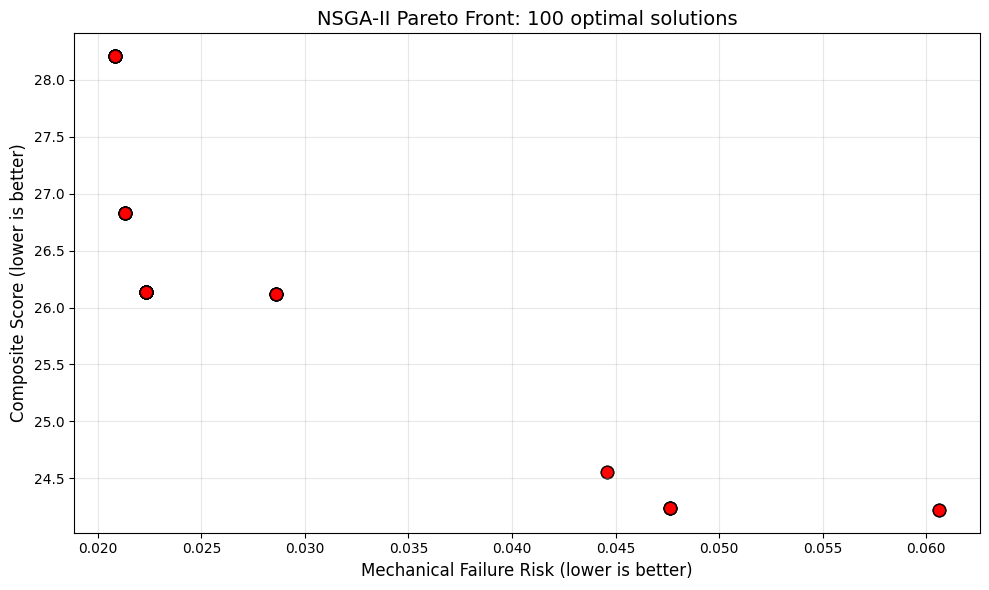

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_pareto["mech_fail_risk"], df_pareto["composite_score"], 
          s=80, alpha=0.7, c="red", edgecolors="black", linewidth=1)

ax.set_xlabel("Mechanical Failure Risk (lower is better)", fontsize=12)
ax.set_ylabel("Composite Score (lower is better)", fontsize=12)
ax.set_title(f"NSGA-II Pareto Front: {len(df_pareto)} optimal solutions", fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Select Diverse Solutions from Pareto Front

Use max-min distance algorithm to select representative solutions spread across the trade-off curve.

In [12]:
def select_diverse_solutions(df, n_select=12):
    """Select n diverse solutions from Pareto front using max-min distance."""
    if len(df) <= n_select:
        return df.copy()
    
    # Normalize objectives to [0,1] for distance calculation
    risk_min, risk_max = df["mech_fail_risk"].min(), df["mech_fail_risk"].max()
    score_min, score_max = df["composite_score"].min(), df["composite_score"].max()
    
    risk_norm = (df["mech_fail_risk"] - risk_min) / (risk_max - risk_min + 1e-9)
    score_norm = (df["composite_score"] - score_min) / (score_max - score_min + 1e-9)
    
    points = np.column_stack([risk_norm.values, score_norm.values])
    
    # Start with the two extreme points
    selected_idx = [df["mech_fail_risk"].idxmin(), df["composite_score"].idxmin()]
    selected_idx = list(set(selected_idx))  # Remove duplicates
    
    # Greedily add points that maximize minimum distance to selected set
    while len(selected_idx) < n_select:
        best_idx = None
        best_min_dist = -1
        
        for i in df.index:
            if i in selected_idx:
                continue
            min_dist = min(np.linalg.norm(points[i] - points[j]) for j in selected_idx)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_idx = i
        
        if best_idx is not None:
            selected_idx.append(best_idx)
        else:
            break
    
    return df.loc[selected_idx].sort_values("mech_fail_risk").reset_index(drop=True)

n_select = 12
df_diverse = select_diverse_solutions(df_pareto, n_select=n_select)
print(f"Selected {len(df_diverse)} diverse solutions from {len(df_pareto)} Pareto-optimal plans")

Selected 12 diverse solutions from 100 Pareto-optimal plans


In [ ]:
print(f"Diverse Pareto-Optimal Solutions ({len(df_diverse)} plans):\n")
df_diverse

Diverse Pareto-Optimal Solutions (12 plans):



,UIV_implant,num_interbody_fusion_levels,ALIF,XLIF,TLIF,num_rods,num_pelvic_screws,osteotomy,mech_fail_risk,composite_score
0,PS,4,0,0,0,4,4,0,0.020836,28.208784
1,PS,4,0,0,0,4,5,0,0.020836,28.208784
2,Hook,4,0,0,0,5,1,0,0.021290,26.825990
3,Hook,4,0,0,0,4,1,0,0.021290,26.825990
4,Hook,4,0,0,0,4,5,0,0.022307,26.136060
5,Hook,0,0,1,1,4,4,0,0.028590,26.116604
6,Hook,0,0,1,1,4,4,0,0.028590,26.116604
7,PS,4,1,1,1,5,6,0,0.044574,24.557021
8,PS,4,1,1,0,4,5,0,0.044574,24.557021
9,Hook,4,1,0,0,5,5,0,0.047641,24.240885


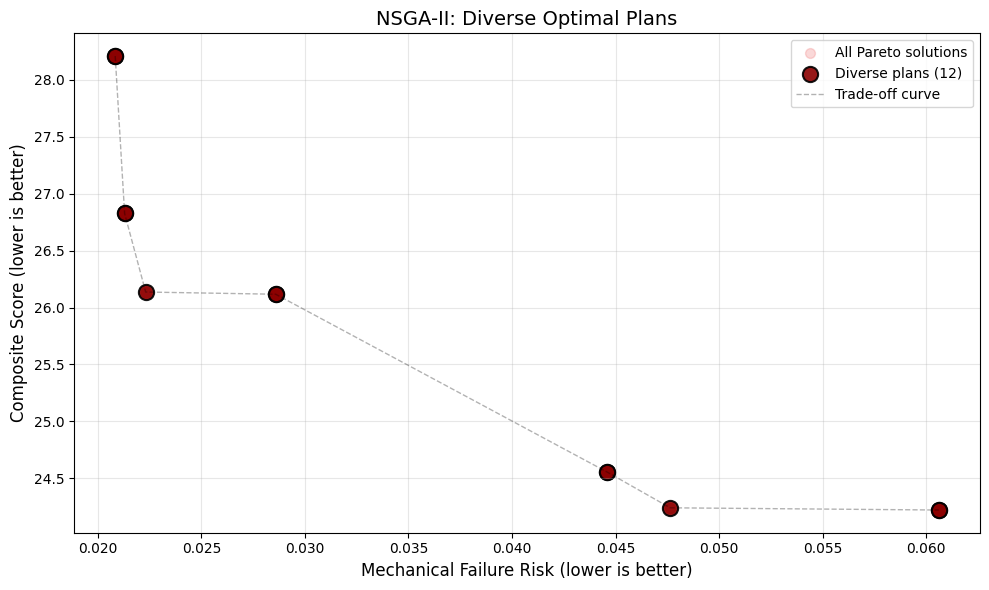

In [14]:
# Visualize diverse solutions on Pareto front
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df_pareto["mech_fail_risk"], df_pareto["composite_score"], 
          alpha=0.3, s=50, label="All Pareto solutions", color="lightcoral")
ax.scatter(df_diverse["mech_fail_risk"], df_diverse["composite_score"], 
          alpha=0.9, s=120, label=f"Diverse plans ({len(df_diverse)})", color="darkred", edgecolors="black", linewidth=1.5)

# Connect points to show trade-off curve
df_sorted = df_diverse.sort_values("mech_fail_risk")
ax.plot(df_sorted["mech_fail_risk"], df_sorted["composite_score"],
        'k--', alpha=0.3, linewidth=1, label="Trade-off curve")

ax.set_xlabel("Mechanical Failure Risk (lower is better)", fontsize=12)
ax.set_ylabel("Composite Score (lower is better)", fontsize=12)
ax.set_title("NSGA-II: Diverse Optimal Plans", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()